# 1 Let's try to play with data

In [1]:
import gzip
import tqdm.notebook as tqdm
from collections import defaultdict
import json

f = open("../data/goodreads_reviews_spoiler.json")
lines = []
for i in tqdm.tqdm(range(1378033)):
    lines.append(json.loads(f.readline()))

In [2]:
import random
len(lines)
random.shuffle(lines)
test_size = int(len(lines)*0.2)
test_lines = lines[:test_size]
valid_lines = lines[test_size:test_size+10000]
train_lines = lines[test_size+10000:]

1378033

In [3]:
lines[0]

{'user_id': '8842281e1d1347389f2ab93d60773d4d',
 'timestamp': '2017-08-30',
 'review_sentences': [[0, 'This is a special book.'],
  [0,
   'It started slow for about the first third, then in the middle third it started to get interesting, then the last third blew my mind.'],
  [0,
   'This is what I love about good science fiction - it pushes your thinking about where things can go.'],
  [0,
   "It is a 2015 Hugo winner, and translated from its original Chinese, which made it interesting in just a different way from most things I've read."],
  [0,
   'For instance the intermixing of Chinese revolutionary history - how they kept accusing people of being "reactionaries", etc.'],
  [0, 'It is a book about science, and aliens.'],
  [0,
   'The science described in the book is impressive - its a book grounded in physics and pretty accurate as far as I could tell.'],
  [1,
   'Though when it got to folding protons into 8 dimensions I think he was just making stuff up - interesting to think a

In [4]:
import numpy as np
n_spoiler_reviews = np.sum([line['has_spoiler'] for line in lines])
n_spoiler_reviews, n_spoiler_reviews/len(lines)

(89627, 0.06503980673902585)

In [5]:
import numpy as np
n_spoiler_sentences = np.sum([sentence[0] for line in lines for sentence in line['review_sentences']])
n_sentences = np.sum([len(line['review_sentences']) for line in lines])
n_spoiler_sentences, n_sentences, n_spoiler_sentences/n_sentences

(569724, 17672655, 0.03223760097167064)

In [6]:
sentences = [sentence[1] for line in lines for sentence in line['review_sentences']]
labels = [sentence[0] for sentence in sentences]

In [7]:
import string
from nltk.stem.porter import *

stemmer = PorterStemmer()
punctuation = set(string.punctuation)

def clean_review(sentence):
    return ''.join([c for c in sentence.lower() if c not in punctuation])

words = defaultdict(int)
    
for line in tqdm.tqdm(lines):
    for sentence in line['review_sentences']:
        sentence = clean_review(sentence[1])
        if (sentence != '') and (sentence is not None):
            for word in sentence.split():
                words[word] += 1

Let's stem these words.

In [8]:
stem_words = defaultdict(int)
map_stem_words = {}
for word in tqdm.tqdm(list(words.keys())):
    stem_word = stemmer.stem(word)
    map_stem_words[word] = stem_word
    stem_words[stem_word] += words[word]

Let's look at some high-frequency words.

In [9]:
counts = [(stem_words[w], w) for w in stem_words]
counts.sort()
counts.reverse()

counts[:20]

[(12689322, 'the'),
 (8411444, 'and'),
 (7832234, 'i'),
 (6832296, 'to'),
 (6524879, 'a'),
 (5653305, 'of'),
 (5082446, 'it'),
 (3898974, 'that'),
 (3687311, 'is'),
 (3661654, 'in'),
 (3514977, 'wa'),
 (3468597, 'thi'),
 (3132365, 'book'),
 (2491119, 'but'),
 (2272462, 'for'),
 (2082090, 'her'),
 (2049041, 'with'),
 (1789251, 'she'),
 (1624647, 'read'),
 (1615469, 'be')]

# 1.5 Basic Test for Whole Review

## 1.5.1 Get the most 10000 popular words

In [10]:
word_bags = counts[:10000]
popular_words = set([word[1]for word in word_bags])

## 1.5.2 Merge Sentences into Reviews

In [11]:
reviews = defaultdict(set)
for line in tqdm.tqdm(lines):
    book_id = line['book_id']
    sentences = line['review_sentences']
    label = line['has_spoiler']
    paragraph = ''
    for sentence in sentences:
        paragraph = paragraph + " " + clean_review(sentence[1])
    reviews[book_id].add((paragraph, label))

Let's split each paragraph into list of words.

In [12]:
splitted_review = defaultdict(set)
for book_id in tqdm.tqdm(reviews):
    for paragraph, label in reviews[book_id]:
        new_paragraph = []
        for word in paragraph.split():
            new_paragraph.append(map_stem_words[word])
        splitted_review[book_id].add((" ".join(new_paragraph), label))

## 1.5.3 Let's compute Document Frequency (DF)

In [13]:
DF = defaultdict(int)
for book_id in tqdm.tqdm(splitted_review):
    for paragraph, _ in splitted_review[book_id]:
        all_words = set(paragraph.split())
        for word in all_words:
            if word in popular_words:
                DF[word+"-"+book_id] += 1

In [14]:
final_DF = defaultdict(float)
for book_id in tqdm.tqdm(splitted_review):
    d_i = len(splitted_review[book_id])
    for word in popular_words:
        if (word+"-"+book_id) in DF:
            final_DF[word+"-"+book_id] = DF[word+"-"+book_id] / d_i

In [15]:
DF = final_DF

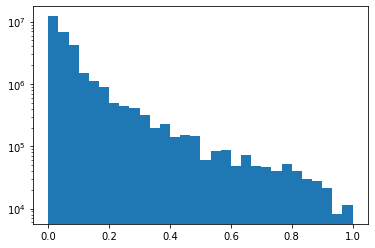

In [49]:
plt.hist(DF.values(), bins = 30)
plt.yscale('log', nonposy='clip')
plt.show()

## 1.5.4 Let's compute Inverse Item Frequency (IIF)

In [46]:
IF = defaultdict(float)
epsilon = 1e-5
for book_id in tqdm.tqdm(splitted_review):
    whole_paragraph = ''
    for paragraph, _ in splitted_review[book_id]:
        whole_paragraph += ' ' + paragraph
    all_words = set(whole_paragraph.split())
    for word in all_words:
        if word in popular_words:
            IF[word] += 1

IIF = defaultdict(float)    
for word in IF:
    IIF[word] = - np.log((IF[word] + epsilon) / (len(splitted_review) + epsilon))

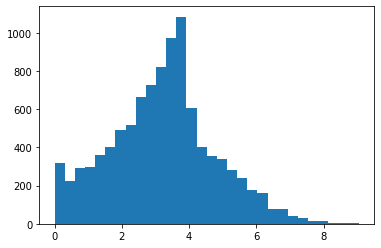

In [47]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(IIF.values(), bins = 30)
plt.show()

## 1.5.5 Let's compute DF-IIF

In [50]:
DF_IIF = defaultdict(float)
for word_book_id in tqdm.tqdm(DF):
    try:
        word, book_id = word_book_id.split("-")
    except:
        print(word_book_id)
    DF_IIF[word_book_id] = DF[word_book_id] * IIF[word]

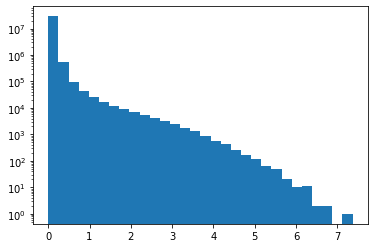

In [52]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(DF_IIF.values(), bins = 30)
plt.yscale('log', nonposy='clip')
plt.show()

In [ ]:
counts = [(DF_IIF[w], w) for w in DF_IIF]

In [94]:
counts.sort(key=lambda kv: kv[0])
counts.reverse()

counts[:20]

[(7.372863511243882, 'eadlyn-22895349'),
 (6.828810356841093, 'naji-13584141'),
 (6.81324799116547, 'zarek-6652338'),
 (6.535722304574935, 'reena-18113193'),
 (6.5078664355992215, 'mateo-34925164'),
 (6.383787812802067, 'aza-22864466'),
 (6.338606146338965, 'everli-23166903'),
 (6.312529617499106, 'naz-28670916'),
 (6.262522633238889, 'vivi-9615212'),
 (6.255329012152291, 'nastya-16088305'),
 (6.2339189702538125, 'xcor-31356376'),
 (6.195198767462519, 'everli-27416023'),
 (6.156468626734025, 'killian-30171411'),
 (6.155351795592731, 'aysel-23301770'),
 (6.152176553799584, 'everli-27015397'),
 (6.144052926036569, 'jacinda-958540'),
 (6.056220436591529, 'etta-22456945'),
 (6.034578830375743, 'jt-22847886'),
 (6.021843821569989, 'gamach-33602101'),
 (5.990451602885654, 'audra-34382818')]

In [96]:
counts[:190]

[(7.372863511243882, 'eadlyn-22895349'),
 (6.828810356841093, 'naji-13584141'),
 (6.81324799116547, 'zarek-6652338'),
 (6.535722304574935, 'reena-18113193'),
 (6.5078664355992215, 'mateo-34925164'),
 (6.383787812802067, 'aza-22864466'),
 (6.338606146338965, 'everli-23166903'),
 (6.312529617499106, 'naz-28670916'),
 (6.262522633238889, 'vivi-9615212'),
 (6.255329012152291, 'nastya-16088305'),
 (6.2339189702538125, 'xcor-31356376'),
 (6.195198767462519, 'everli-27416023'),
 (6.156468626734025, 'killian-30171411'),
 (6.155351795592731, 'aysel-23301770'),
 (6.152176553799584, 'everli-27015397'),
 (6.144052926036569, 'jacinda-958540'),
 (6.056220436591529, 'etta-22456945'),
 (6.034578830375743, 'jt-22847886'),
 (6.021843821569989, 'gamach-33602101'),
 (5.990451602885654, 'audra-34382818'),
 (5.963302749714725, 'avri-13124584'),
 (5.945857670357968, 'eadlyn-24965992'),
 (5.926101169407434, 'jaron-18222545'),
 (5.9188925734316244, 'kricket-24931971'),
 (5.91700972545898, 'sutter-17620971'),
 

## 1.5.6 Save Parameters

In [53]:
import pickle
with open('../data/DF-IIF.pkl', 'w+') as f:
    json.dump({'DF':DF, 'IIF':IIF, 'DF-IIF':DF_IIF}, f)

# 2 Let's do some basic statistics.

## 2.1 Compute Histogram For Non-Spoiler Paragraph and Spoiler Paragraph

In [ ]:
DF_IIF_no_spoiler = defaultdict(int)
DF_IIF_spoiler = defaultdict(int)
for book_id in tqdm.tqdm(splitted_review):
    for paragraph, label in splitted_review[book_id]:
        result = defaultdict(int)
        words = paragraph.split()
        for word in words:
            if word in popular_words:
                result[word] += 1
        if label == 1:
            for word in result:
                DF_IIF_spoiler[word+"-"+book_id] += result[word]
        else:
            for word in result:
                DF_IIF_no_spoiler[word+"-"+book_id] += result[word]
                
counts_no_spoiler = DF_IIF_no_spoiler
counts_spoiler = DF_IIF_spoiler

In [78]:
def find_bin(freq, n_bins=30):
    return int(freq*n_bins)

DF_IIF_no_spoiler = defaultdict(int)
DF_IIF_spoiler = defaultdict(int)
for word in tqdm.tqdm(counts_no_spoiler):
    DF_IIF_no_spoiler[find_bin(DF_IIF[word])] += counts_no_spoiler[word]

for word in tqdm.tqdm(counts_spoiler):
    DF_IIF_spoiler[find_bin(DF_IIF[word])] += counts_spoiler[word]    

In [85]:
no_spoiler_sum = np.sum(list(DF_IIF_no_spoiler.values()))
for key in tqdm.tqdm(DF_IIF_no_spoiler):
    DF_IIF_no_spoiler[key] = DF_IIF_no_spoiler[key] / no_spoiler_sum
    
spoiler_sum = np.sum(list(DF_IIF_spoiler.values()))
for key in tqdm.tqdm(DF_IIF_spoiler):
    DF_IIF_spoiler[key] = DF_IIF_spoiler[key] / spoiler_sum    

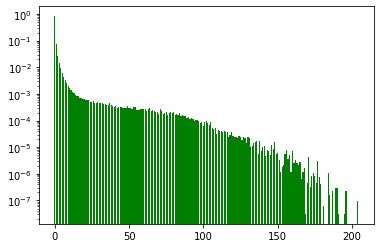

In [86]:
plt.bar(DF_IIF_spoiler.keys(), DF_IIF_spoiler.values(), color='g')
plt.yscale('log', nonposy='clip')
plt.show()

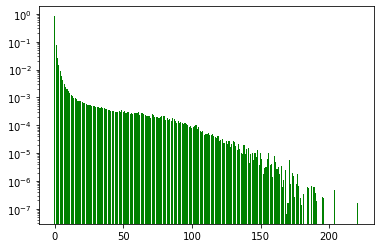

In [87]:
plt.bar(DF_IIF_no_spoiler.keys(), DF_IIF_no_spoiler.values(), color='g')
plt.yscale('log', nonposy='clip')
plt.show()

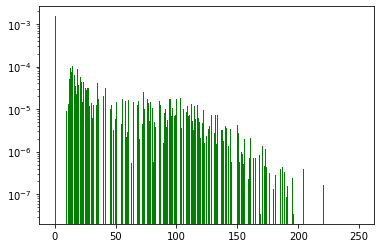

In [91]:
difference = defaultdict(int)
for i in range(250):
    difference[i] = DF_IIF_no_spoiler[i] - DF_IIF_spoiler[i]
plt.bar(difference.keys(), difference.values(), color='g')
plt.yscale('log', nonposy='clip')
plt.show()

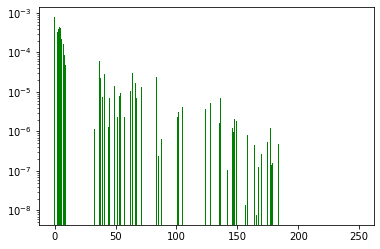

In [92]:
difference = defaultdict(int)
for i in range(250):
    difference[i] = DF_IIF_spoiler[i] - DF_IIF_no_spoiler[i]
plt.bar(difference.keys(), difference.values(), color='g')
plt.yscale('log', nonposy='clip')
plt.show()